In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pu_loss import PULoss, PULossWrapped, PURankingLoss
from data_loader import *
from utils import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda:0


In [2]:
dataset = Epilepsy2Dataset()

In [3]:
X, y = dataset.data.numpy(), dataset.labels.numpy()
X.shape

(11500, 178)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [6]:
positive_class=1
unlabeled_fraction = 0.5

In [7]:
y_train_pu, unlabeled_idx_train = make_pu_labels(y_train, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
y_test_pu, unlabeled_idx_test = make_pu_labels(y_test, positive_class=positive_class, unlabeled_fraction=unlabeled_fraction)
print((y_train[y_train == 1]).shape)
print((y_train_pu[y_train_pu == 1]).shape)
print((y_test[y_test == 1]).shape)
print((y_test_pu[y_test_pu == 1]).shape)

(1610,)
(805,)
(690,)
(345,)


In [156]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_pu_tensor = torch.tensor(y_train_pu, dtype=torch.long)
y_test_pu_tensor = torch.tensor(y_test_pu, dtype=torch.long)

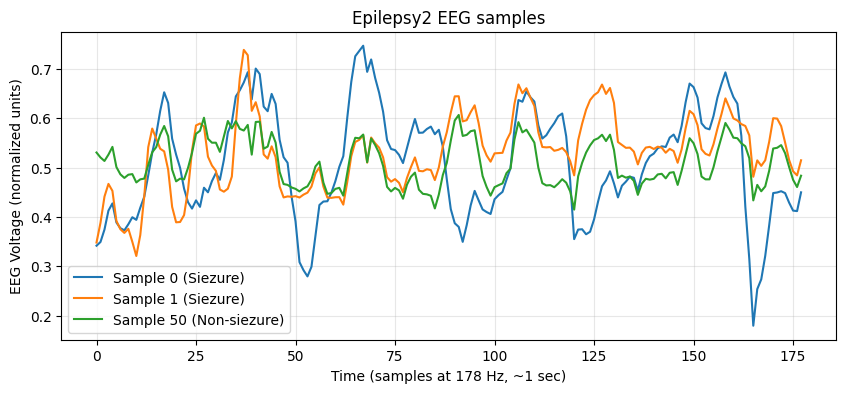

In [11]:
visualize_samples(dataset, [0, 1, 50])

## InceptionTime

In [9]:
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [10]:
positive_prior = torch.tensor(y_train_pu.mean(), dtype=torch.float32)
positive_prior

tensor(0.1000)

In [ ]:
X_tr_tensor = X_tr_tensor.view(X_tr_tensor.shape[0], 1, -1)

In [36]:
from tsai.all import *
from pu_loss import PULoss, PULossWrapped
from sklearn.utils.class_weight import compute_class_weight
from fastai.callback.tracker import SaveModelCallback

# Try PU problem with CrossEntropyLoss

from sklearn.metrics import f1_score, precision_score
from tsai.metrics import skm_to_fastai

f1_macro = skm_to_fastai(f1_score, average="macro")
precision_macro = skm_to_fastai(precision_score, average="macro")

criterion = nn.CrossEntropyLoss()

X_all = np.concatenate([X_train, X_test]).astype(np.float32)
y_all = np.concatenate([y_train_pu, y_test_pu])

splits = (list(range(len(y_train_pu))),
         list(range(len(y_train_pu), len(y_all))))

classes = np.unique(y_all)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_all[splits[0]])
ce_weight = torch.tensor(weights, dtype=torch.float32)
criterion = nn.CrossEntropyLoss(weight=ce_weight)

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)


epoch,train_loss,train_accuracy,train_precision_score,train_f1_score,valid_loss,valid_accuracy,valid_precision_score,valid_f1_score,time
0,0.455984,0.787500,0.640008,0.656534,0.323442,0.873913,0.718536,0.765635,00:05
1,0.305005,0.872375,0.715116,0.761165,0.299929,0.891884,0.729845,0.774921,00:05
2,0.266625,0.874250,0.717880,0.764749,0.249107,0.875072,0.720224,0.767790,00:04
3,0.249831,0.879000,0.722810,0.770698,0.250522,0.876812,0.722246,0.770349,00:04
4,0.236178,0.881625,0.727047,0.776037,0.244639,0.871014,0.717281,0.764032,00:04
5,0.222722,0.885625,0.731908,0.782187,0.257346,0.859710,0.707205,0.750589,00:04
6,0.210454,0.888500,0.734724,0.785617,0.248252,0.889565,0.733479,0.783116,00:04
7,0.203055,0.893750,0.741897,0.794339,0.246814,0.892464,0.736986,0.787107,00:04
8,0.186874,0.897375,0.746507,0.799667,0.242536,0.891304,0.736835,0.787547,00:04
9,0.184091,0.901125,0.751267,0.805123,0.245443,0.894203,0.739939,0.790887,00:05


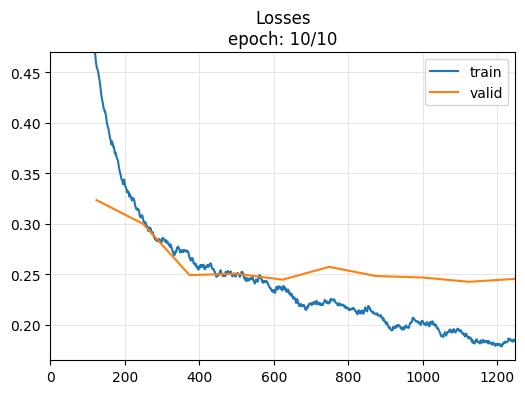

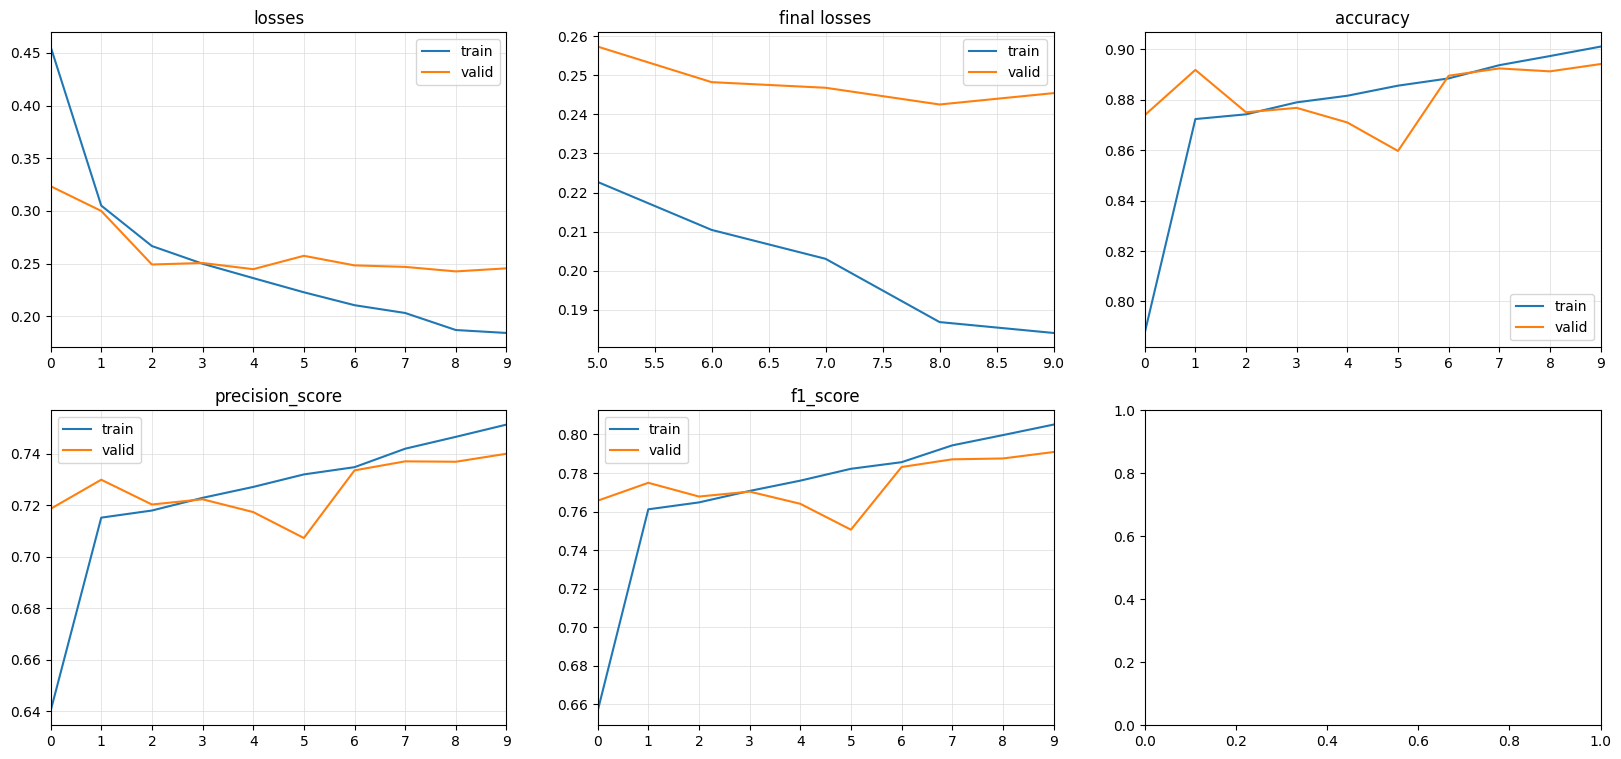

In [37]:
clf.fit_one_cycle(10, 1e-4)

In [43]:
clf.save("epilepsy_inctime_entropy")

Path('models/epilepsy_inctime_entropy.pth')

### Results

In [ ]:
X_all = X_all.reshape(X_all.shape[0], 1, X_all.shape[1])
X_all.shape

(11500, 1, 178)

In [39]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9997    0.8911    0.9423      7245
           1     0.5044    0.9975    0.6700       805

    accuracy                         0.9017      8050
   macro avg     0.7520    0.9443    0.8061      8050
weighted avg     0.9502    0.9017    0.9150      8050

[[6456  789]
 [   2  803]]


In [40]:
probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9867    0.9894    0.9881      6440
           1     0.9573    0.9466    0.9519      1610

    accuracy                         0.9809      8050
   macro avg     0.9720    0.9680    0.9700      8050
weighted avg     0.9808    0.9809    0.9808      8050

[[6372   68]
 [  86 1524]]


In [41]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9946    0.8873    0.9379      3105
           1     0.4853    0.9565    0.6439       345

    accuracy                         0.8942      3450
   macro avg     0.7399    0.9219    0.7909      3450
weighted avg     0.9437    0.8942    0.9085      3450

[[2755  350]
 [  15  330]]


In [75]:
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9834    0.9870    0.9852      2760
           1     0.9471    0.9333    0.9401       690

    accuracy                         0.9762      3450
   macro avg     0.9652    0.9601    0.9627      3450
weighted avg     0.9761    0.9762    0.9762      3450

[[2724   36]
 [  46  644]]


In [46]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of true positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of true positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of true positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 721
In percentage: 0.8957
Test
Total number of true positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 314
In percentage: 0.9101


In [ ]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = y_test
probs = F.softmax(probas, dim=1)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = (probs >= 0.5).numpy().astype(int)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


Average Precision: 0.9759
F1 at threshold 0.5: 0.9401
Fixed F1 >= 0.9401:
Threshold = 0.4873, Precision = 0.9471, F1 = 0.9409, Recall = 0.9348


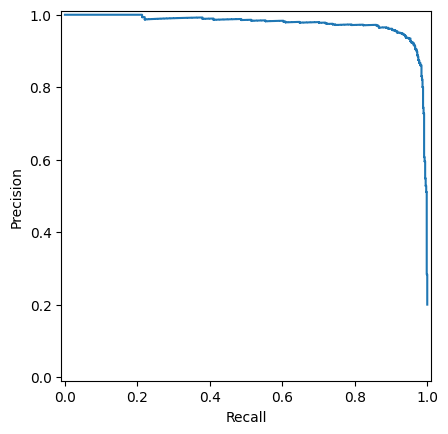

In [97]:
disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.show()

In [108]:
criterion = PULossWrapped(prior=positive_prior, nnPU=True)

tfms = [None, TSClassification()]
batch_tfms = TSStandardize(by_sample=True)

clf = TSClassifier(X_all, y_all, splits=splits, arch="InceptionTimePlus",
                   tfms=tfms, batch_tfms=batch_tfms,train_metrics=True, loss_func=criterion,
                   metrics=[accuracy, precision_macro, f1_macro], cbs=ShowGraph(), wd=1e-3)

epoch,train_loss,train_accuracy,train_precision_score,train_f1_score,valid_loss,valid_accuracy,valid_precision_score,valid_f1_score,time


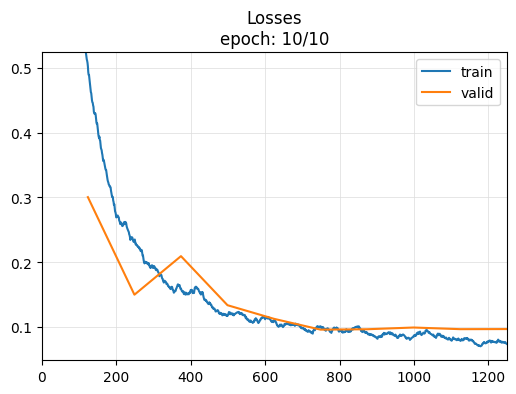

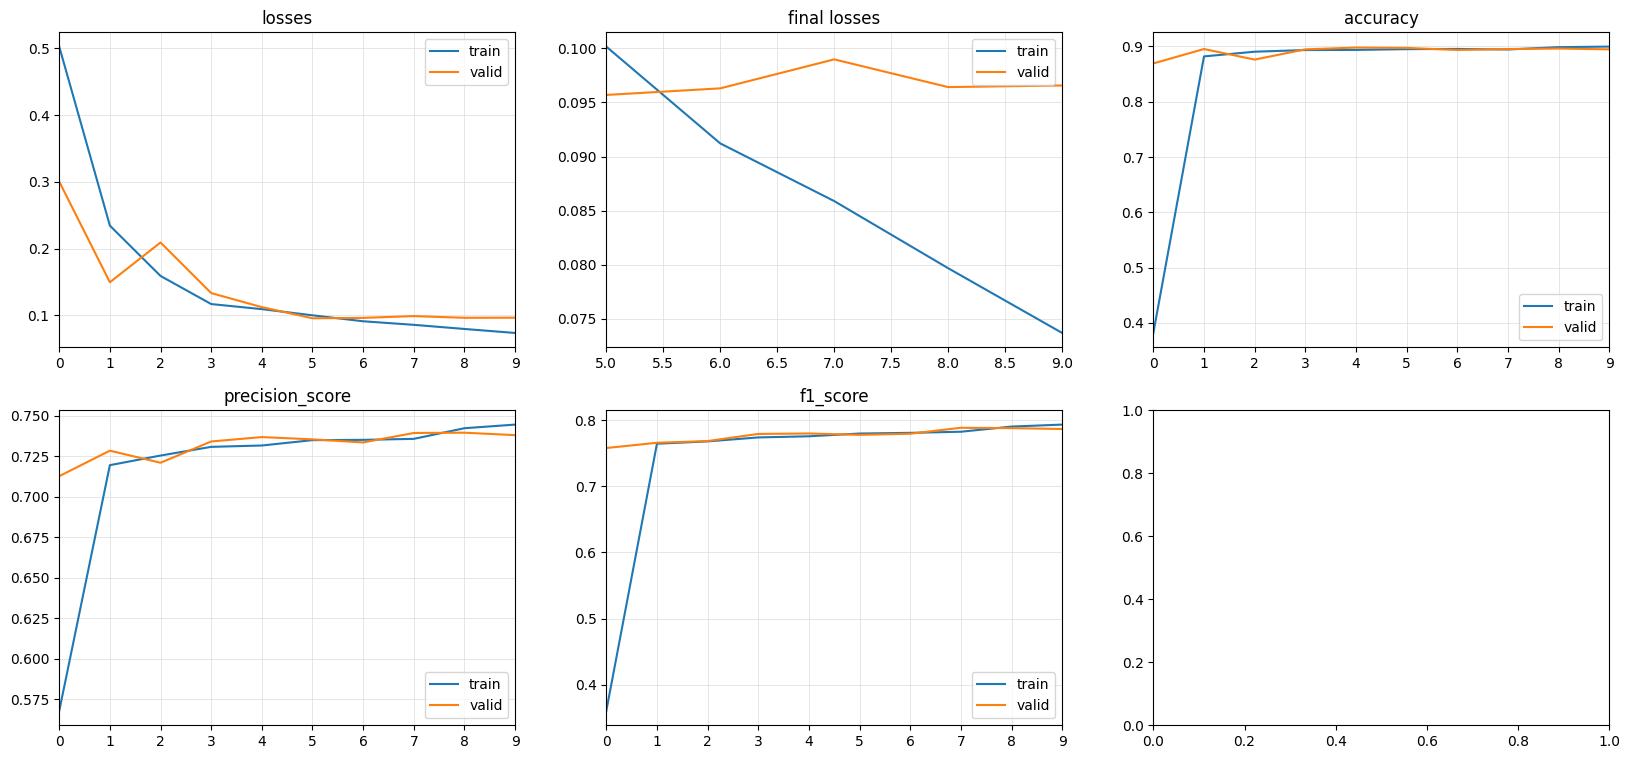

In [109]:
clf.fit_one_cycle(10, 1e-4)

In [115]:
clf.save("epilepsy_inctime_nnpu")

Path('models/epilepsy_inctime_nnpu.pth')

In [110]:
# Train metrics

probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9917    0.8954    0.9411      7245
           1     0.4977    0.9329    0.6491       805

    accuracy                         0.8991      8050
   macro avg     0.7447    0.9141    0.7951      8050
weighted avg     0.9423    0.8991    0.9119      8050

[[6487  758]
 [  54  751]]


In [111]:
probas, target = clf.get_X_preds(X_all[splits[0]], y_all[splits[0]], with_decoded=False)
preds_train = probas.argmax(dim=-1)
print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9766    0.9919    0.9842      6440
           1     0.9655    0.9050    0.9343      1610

    accuracy                         0.9745      8050
   macro avg     0.9711    0.9484    0.9592      8050
weighted avg     0.9744    0.9745    0.9742      8050

[[6388   52]
 [ 153 1457]]


In [112]:
# Test metrics

probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test_pu, preds_test, digits=4))
print(confusion_matrix(y_test_pu, preds_test))

              precision    recall  f1-score   support

           0     0.9896    0.8924    0.9385      3105
           1     0.4862    0.9159    0.6352       345

    accuracy                         0.8948      3450
   macro avg     0.7379    0.9042    0.7869      3450
weighted avg     0.9393    0.8948    0.9082      3450

[[2771  334]
 [  29  316]]


In [113]:
probas, target = clf.get_X_preds(X_all[splits[1]], y_all[splits[1]], with_decoded=False)
preds_test = probas.argmax(dim=-1)
print(classification_report(y_test, preds_test, digits=4))
print(confusion_matrix(y_test, preds_test))

              precision    recall  f1-score   support

           0     0.9736    0.9877    0.9806      2760
           1     0.9477    0.8928    0.9194       690

    accuracy                         0.9687      3450
   macro avg     0.9606    0.9402    0.9500      3450
weighted avg     0.9684    0.9687    0.9683      3450

[[2726   34]
 [  74  616]]


In [114]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(preds_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(preds_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1509
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 706
In percentage: 0.8770
Test
Total number of positive sampels:650
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 300
In percentage: 0.8696


In [124]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = y_test
probs = F.softmax(probas, dim=1)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = (probs >= 0.5).numpy().astype(int)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


Average Precision: 0.9780
F1 at threshold 0.5: 0.9194
Fixed F1 >= 0.9194:
Threshold = 0.5212, Precision = 0.9563, F1 = 0.9203, Recall = 0.8870


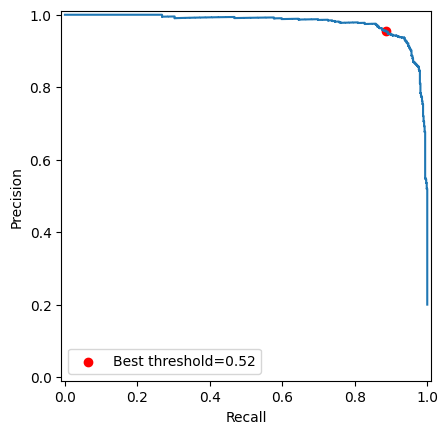

In [ ]:
disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.scatter(best_recall, best_precision, color='red', label=f'Best threshold={best_threshold:.2f}')
plt.legend()
plt.show()

## CNN

In [157]:
batch_size = 64
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 1, 178])


In [169]:
positive_prior = torch.tensor(y_train_pu.mean(), dtype=torch.float32)
positive_prior

tensor(0.1000)

In [170]:
in_channel = X_train_tensor.shape[1]
seq_length = X_train_tensor.shape[2]
n_output = len(y_train_pu_tensor.unique())
print(f'in_channel: {in_channel}, sequence_length: {seq_length}, n_output: {n_output}')
n_hidden = 64
num_epochs = 15
lr = 0.0001

in_channel: 1, sequence_length: 178, n_output: 2


In [182]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5696, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=2, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5696, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [183]:
#criterion = PULossWrapped(prior=positive_prior)
from sklearn.utils.class_weight import compute_class_weight
classes = np.unique(y_test_pu)
weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_test_pu)
ce_weight = torch.tensor(weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(weight=ce_weight)


In [184]:
model = train(model, criterion, train_loader, test_loader, 0.0001, 15, device)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:00<00:00, 179.19it/s]


Epoch [1/15], tr_loss: 0.69412 tr_acc: 0.71019 test_loss: 0.68918, test_acc: 0.90000


100%|██████████| 126/126 [00:00<00:00, 240.39it/s]


Epoch [2/15], tr_loss: 0.67888 tr_acc: 0.82037 test_loss: 0.65718, test_acc: 0.90116


100%|██████████| 126/126 [00:00<00:00, 288.90it/s]


Epoch [3/15], tr_loss: 0.61474 tr_acc: 0.85453 test_loss: 0.54994, test_acc: 0.89652


100%|██████████| 126/126 [00:00<00:00, 250.37it/s]


Epoch [4/15], tr_loss: 0.50457 tr_acc: 0.89056 test_loss: 0.45969, test_acc: 0.89391


100%|██████████| 126/126 [00:00<00:00, 258.90it/s]


Epoch [5/15], tr_loss: 0.44523 tr_acc: 0.89019 test_loss: 0.42337, test_acc: 0.89072


100%|██████████| 126/126 [00:00<00:00, 260.36it/s]


Epoch [6/15], tr_loss: 0.41678 tr_acc: 0.88857 test_loss: 0.40210, test_acc: 0.88899


100%|██████████| 126/126 [00:00<00:00, 264.76it/s]


Epoch [7/15], tr_loss: 0.39960 tr_acc: 0.88671 test_loss: 0.38724, test_acc: 0.88551


100%|██████████| 126/126 [00:00<00:00, 259.07it/s]


Epoch [8/15], tr_loss: 0.38747 tr_acc: 0.88596 test_loss: 0.37541, test_acc: 0.88406


100%|██████████| 126/126 [00:00<00:00, 280.03it/s]


Epoch [9/15], tr_loss: 0.37679 tr_acc: 0.88360 test_loss: 0.36464, test_acc: 0.88087


100%|██████████| 126/126 [00:00<00:00, 259.14it/s]


Epoch [10/15], tr_loss: 0.36395 tr_acc: 0.88248 test_loss: 0.35280, test_acc: 0.87681


100%|██████████| 126/126 [00:00<00:00, 248.07it/s]


Epoch [11/15], tr_loss: 0.35095 tr_acc: 0.88236 test_loss: 0.35076, test_acc: 0.86087


100%|██████████| 126/126 [00:00<00:00, 241.43it/s]


Epoch [12/15], tr_loss: 0.34191 tr_acc: 0.88137 test_loss: 0.33560, test_acc: 0.86899


100%|██████████| 126/126 [00:00<00:00, 213.15it/s]


Epoch [13/15], tr_loss: 0.33392 tr_acc: 0.87851 test_loss: 0.33097, test_acc: 0.86174


100%|██████████| 126/126 [00:00<00:00, 264.84it/s]


Epoch [14/15], tr_loss: 0.32653 tr_acc: 0.87764 test_loss: 0.32467, test_acc: 0.85971


100%|██████████| 126/126 [00:00<00:00, 292.33it/s]


Epoch [15/15], tr_loss: 0.32046 tr_acc: 0.87615 test_loss: 0.32064, test_acc: 0.85797


In [185]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train_pu, preds_train, digits=4))
print(confusion_matrix(y_train_pu, preds_train))

              precision    recall  f1-score   support

           0     0.9907    0.8511    0.9156      7245
           1     0.4091    0.9280    0.5678       805

    accuracy                         0.8588      8050
   macro avg     0.6999    0.8895    0.7417      8050
weighted avg     0.9325    0.8588    0.8808      8050

[[6166 1079]
 [  58  747]]


In [186]:
model.eval()
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.max(out_train, 1)[1]

print(classification_report(y_train, preds_train, digits=4))
print(confusion_matrix(y_train, preds_train))

              precision    recall  f1-score   support

           0     0.9809    0.9480    0.9642      6440
           1     0.8165    0.9261    0.8679      1610

    accuracy                         0.9436      8050
   macro avg     0.8987    0.9370    0.9160      8050
weighted avg     0.9480    0.9436    0.9449      8050

[[6105  335]
 [ 119 1491]]


In [187]:
y_test_pu = y_test_pu_tensor.numpy()

In [188]:
model.eval()
out_test = model(X_test_tensor.to(device))
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test_pu, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_pu, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9910    0.8499    0.9150      3105
           1     0.4079    0.9304    0.5671       345

    accuracy                         0.8580      3450
   macro avg     0.6994    0.8902    0.7411      3450
weighted avg     0.9327    0.8580    0.8803      3450

[[2639  466]
 [  24  321]]


In [189]:
model.eval()
out_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.max(out_test, 1)[1]

print(classification_report(y_test, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

           0     0.9793    0.9449    0.9618      2760
           1     0.8069    0.9203    0.8599       690

    accuracy                         0.9400      3450
   macro avg     0.8931    0.9326    0.9108      3450
weighted avg     0.9448    0.9400    0.9414      3450

[[2608  152]
 [  55  635]]


In [190]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 744
In percentage: 0.9242
Test
Total number of positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 314
In percentage: 0.9101


In [191]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = y_test
probs = F.softmax(out_test, dim=1)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = (probs >= 0.5).numpy().astype(int)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


Average Precision: 0.9398
F1 at threshold 0.5: 0.8599
Fixed F1 >= 0.8599:
Threshold = 0.7940, Precision = 0.9323, F1 = 0.8603, Recall = 0.7986


In [192]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels with max precision.
y_pred_prec_fixed = (probs >= best_threshold).numpy().astype(int)

In [193]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
# print("Train")
# correct_preds_num_tr = (preds_train[unlabeled_idx_train] == y_train[unlabeled_idx_train]).sum()
# print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
# Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
# Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
# In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (y_pred_prec_fixed[unlabeled_idx_test] == y_test[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print(confusion_matrix(y_test, y_pred_prec_fixed))


Test
Total number of positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 271
In percentage: 0.7855
[[2720   40]
 [ 139  551]]


In [195]:
torch.save(model.state_dict, "models/epilepsy_cnn_crossent.pth")

### PU

In [196]:
y_train_pu_tensor = torch.tensor(np.where(y_train_pu == 1, 1, -1), dtype=torch.long)
y_test_pu_tensor = torch.tensor(np.where(y_test_pu == 1, 1, -1), dtype=torch.long)
batch_size = 64
print(X_train_tensor.shape)
train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

torch.Size([8050, 1, 178])


In [197]:
positive_prior = torch.where(y_train_pu_tensor == -1, 0, 1).to(torch.float32).mean()
positive_prior

tensor(0.1000)

In [198]:
from baseline import Conv_Net, train, LSTMNet
model = Conv_Net(in_channel, seq_length, n_hidden, n_output=1)
model = model.to(device)
print(model)

Conv_Net(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=5696, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.5, inplace=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=5696, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [223]:
criterion = PULoss(prior=positive_prior, nnPU=True)


In [224]:
model = train(model, criterion, train_loader, test_loader, 0.0001, 15, device)

100%|██████████| 126/126 [00:01<00:00, 99.17it/s] 


Epoch [1/15], tr_loss: 0.13241 tr_acc: 0.89689 test_loss: 0.13812, test_acc: 0.89333


100%|██████████| 126/126 [00:01<00:00, 121.17it/s]


Epoch [2/15], tr_loss: 0.13225 tr_acc: 0.89627 test_loss: 0.14125, test_acc: 0.89217


100%|██████████| 126/126 [00:00<00:00, 131.95it/s]


Epoch [3/15], tr_loss: 0.13648 tr_acc: 0.89627 test_loss: 0.14011, test_acc: 0.89304


100%|██████████| 126/126 [00:01<00:00, 125.35it/s]


Epoch [4/15], tr_loss: 0.13221 tr_acc: 0.89640 test_loss: 0.14052, test_acc: 0.89333


100%|██████████| 126/126 [00:00<00:00, 130.01it/s]


Epoch [5/15], tr_loss: 0.13272 tr_acc: 0.89441 test_loss: 0.14729, test_acc: 0.89333


100%|██████████| 126/126 [00:00<00:00, 126.71it/s]


Epoch [6/15], tr_loss: 0.12919 tr_acc: 0.89615 test_loss: 0.14510, test_acc: 0.89391


100%|██████████| 126/126 [00:00<00:00, 128.75it/s]


Epoch [7/15], tr_loss: 0.13078 tr_acc: 0.89491 test_loss: 0.13174, test_acc: 0.89362


100%|██████████| 126/126 [00:01<00:00, 115.84it/s]


Epoch [8/15], tr_loss: 0.12245 tr_acc: 0.89466 test_loss: 0.13040, test_acc: 0.89043


100%|██████████| 126/126 [00:00<00:00, 139.68it/s]


Epoch [9/15], tr_loss: 0.11792 tr_acc: 0.89404 test_loss: 0.12025, test_acc: 0.89159


100%|██████████| 126/126 [00:00<00:00, 143.62it/s]


Epoch [10/15], tr_loss: 0.11287 tr_acc: 0.89329 test_loss: 0.11664, test_acc: 0.89275


100%|██████████| 126/126 [00:00<00:00, 135.86it/s]


Epoch [11/15], tr_loss: 0.11127 tr_acc: 0.89205 test_loss: 0.11694, test_acc: 0.89333


100%|██████████| 126/126 [00:00<00:00, 139.07it/s]


Epoch [12/15], tr_loss: 0.11322 tr_acc: 0.89280 test_loss: 0.11878, test_acc: 0.89304


100%|██████████| 126/126 [00:00<00:00, 134.80it/s]


Epoch [13/15], tr_loss: 0.10952 tr_acc: 0.89404 test_loss: 0.11670, test_acc: 0.89304


100%|██████████| 126/126 [00:00<00:00, 133.71it/s]


Epoch [14/15], tr_loss: 0.11063 tr_acc: 0.89118 test_loss: 0.11706, test_acc: 0.89304


100%|██████████| 126/126 [00:01<00:00, 124.23it/s]


Epoch [15/15], tr_loss: 0.10897 tr_acc: 0.89478 test_loss: 0.11476, test_acc: 0.89304


In [225]:
model.eval()
y_train_cp = np.where(y_train_pu == 1, 1, -1)
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_cp, preds_train, digits=4))
print(confusion_matrix(y_train_cp, preds_train))

              precision    recall  f1-score   support

          -1     0.9755    0.9016    0.9371      7245
           1     0.4734    0.7963    0.5938       805

    accuracy                         0.8911      8050
   macro avg     0.7245    0.8489    0.7654      8050
weighted avg     0.9253    0.8911    0.9028      8050

[[6532  713]
 [ 164  641]]


In [226]:
model.eval()
y_train_cp = np.where(y_train == 1, 1, -1)
out_train = model(X_train_tensor.to(device)).cpu()
preds_train = torch.where(
            out_train > 0,
            torch.tensor(1, device=out_train.device),
            torch.tensor(-1, device=out_train.device)
        ).view(-1)

print(classification_report(y_train_cp, preds_train, digits=4))
print(confusion_matrix(y_train_cp, preds_train))

              precision    recall  f1-score   support

          -1     0.9492    0.9870    0.9677      6440
           1     0.9380    0.7888    0.8570      1610

    accuracy                         0.9473      8050
   macro avg     0.9436    0.8879    0.9123      8050
weighted avg     0.9470    0.9473    0.9456      8050

[[6356   84]
 [ 340 1270]]


In [227]:
model.eval()
y_test_cp = np.where(y_test_pu == 1, 1, -1)
out_test = model(X_test_tensor.to(device)).cpu()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_cp, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_cp, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9757    0.9037    0.9383      3105
           1     0.4791    0.7971    0.5985       345

    accuracy                         0.8930      3450
   macro avg     0.7274    0.8504    0.7684      3450
weighted avg     0.9260    0.8930    0.9043      3450

[[2806  299]
 [  70  275]]


In [228]:
model.eval()
y_test_cp = np.where(y_test == 1, 1, -1)
out_test = model(X_test_tensor.to(device)).cpu().detach()
preds_test = torch.where(
            out_test > 0,
            torch.tensor(1, device=out_test.device),
            torch.tensor(-1, device=out_test.device)
        ).view(-1)

print(classification_report(y_test_cp, preds_test.cpu().detach().numpy(), digits=4))
print(confusion_matrix(y_test_cp, preds_test.cpu().detach().numpy()))

              precision    recall  f1-score   support

          -1     0.9478    0.9877    0.9674      2760
           1     0.9408    0.7826    0.8544       690

    accuracy                         0.9467      3450
   macro avg     0.9443    0.8851    0.9109      3450
weighted avg     0.9464    0.9467    0.9448      3450

[[2726   34]
 [ 150  540]]


In [229]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (preds_train[unlabeled_idx_train] == np.where(y_train == 0, -1, 1)[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(preds_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == np.where(y_test == 0, -1, 1)[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(preds_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1354
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 629
In percentage: 0.7814
Test
Total number of positive sampels:574
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 265
In percentage: 0.7681


In [230]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = np.where(y_test == 0, -1, 1)
probs = F.sigmoid(out_test)

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = np.where(probs >= 0.5, 1, -1)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


Average Precision: 0.9462
F1 at threshold 0.5: 0.8544
Fixed F1 >= 0.8544:
Threshold = 0.4901, Precision = 0.9412, F1 = 0.8580, Recall = 0.7884


In [231]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels with max precision.
y_pred_prec_fixed = np.where(probs >= best_threshold, 1, -1).squeeze(1)
print("Test")
correct_preds_num_tst = (y_pred_prec_fixed[unlabeled_idx_test] == y_true[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_true==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print(confusion_matrix(y_true, y_pred_prec_fixed))
print(f"Best precision: {best_precision:.4f}")

Test
Total number of positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 268
In percentage: 0.7768
[[2726   34]
 [ 146  544]]
Best precision: 0.9412


In [232]:
torch.save(model.state_dict, "models/epilepsy_cnn_nnpu.pth")

In [ ]:
# We want to value good precision metrics. In the task of EGM, we don't want to mistakengly predict 1, when the actual label is 0 (in other words, we don't want to electrocute when we are in cavity/not near the dysfunctional tissue)

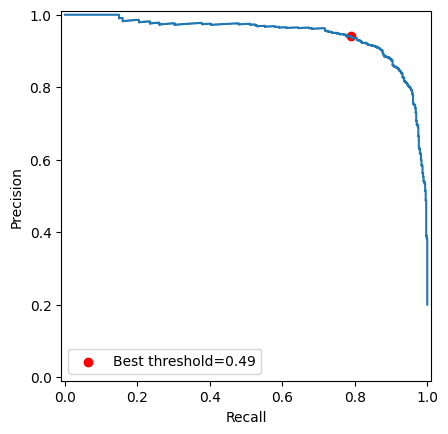

In [233]:
disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.scatter(best_recall, best_precision, color='red', label=f'Best threshold={best_threshold:.2f}')
plt.legend()
plt.show()

## Mamba

In [ ]:
# y_train_pu_tensor = torch.tensor(np.where(y_train_pu == 1, 1, -1), dtype=torch.long)
# y_test_pu_tensor = torch.tensor(np.where(y_test_pu == 1, 1, -1), dtype=torch.long)
# batch_size = 64
# print(X_train_tensor.shape)
# train_dataset = TensorDataset(X_train_tensor, y_train_pu_tensor)
# test_dataset = TensorDataset(X_test_tensor, y_test_pu_tensor)


# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [234]:
from baseline import MambaClassifier, train, PULoss

criterion = PULoss(positive_prior, nnPU=False)
model_mamba = MambaClassifier(in_channel, hidden_dim=128, num_classes=1, num_layers=1, dropout=0.5)
model_mamba = model_mamba.to(device)
print(model_mamba)

MambaClassifier(
  (input_proj): Linear(in_features=1, out_features=128, bias=True)
  (blocks): Sequential(
    (0): MambaBlock(
      (mamba): Mamba(
        (in_proj): Linear(in_features=128, out_features=512, bias=False)
        (conv1d): Conv1d(256, 256, kernel_size=(4,), stride=(1,), padding=(3,), groups=256)
        (act): SiLU()
        (x_proj): Linear(in_features=256, out_features=40, bias=False)
        (dt_proj): Linear(in_features=8, out_features=256, bias=True)
        (out_proj): Linear(in_features=256, out_features=128, bias=False)
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.5, inplace=False)
    )
  )
  (pool): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [235]:
model_mamba = train(model_mamba, criterion, train_loader, test_loader, 0.0001, 15, device)

  0%|          | 0/126 [00:00<?, ?it/s]

100%|██████████| 126/126 [00:02<00:00, 50.48it/s]


Epoch [1/15], tr_loss: 0.32744 tr_acc: 0.90000 test_loss: 0.35399, test_acc: 0.90000


100%|██████████| 126/126 [00:01<00:00, 64.11it/s]


Epoch [2/15], tr_loss: 0.32235 tr_acc: 0.90000 test_loss: 0.34702, test_acc: 0.90000


100%|██████████| 126/126 [00:01<00:00, 64.73it/s]


Epoch [3/15], tr_loss: 0.28576 tr_acc: 0.90000 test_loss: 0.26118, test_acc: 0.90000


100%|██████████| 126/126 [00:01<00:00, 64.21it/s]


Epoch [4/15], tr_loss: 0.22493 tr_acc: 0.89925 test_loss: 0.16784, test_acc: 0.90087


100%|██████████| 126/126 [00:01<00:00, 64.24it/s]


Epoch [5/15], tr_loss: 0.16076 tr_acc: 0.89925 test_loss: 0.14024, test_acc: 0.89652


100%|██████████| 126/126 [00:01<00:00, 63.16it/s]


Epoch [6/15], tr_loss: 0.14048 tr_acc: 0.89665 test_loss: 0.14355, test_acc: 0.89536


100%|██████████| 126/126 [00:02<00:00, 62.24it/s]


Epoch [7/15], tr_loss: 0.13613 tr_acc: 0.89602 test_loss: 0.13670, test_acc: 0.89333


100%|██████████| 126/126 [00:02<00:00, 61.94it/s]


Epoch [8/15], tr_loss: 0.13222 tr_acc: 0.89528 test_loss: 0.13495, test_acc: 0.89420


100%|██████████| 126/126 [00:02<00:00, 61.72it/s]


Epoch [9/15], tr_loss: 0.12980 tr_acc: 0.89553 test_loss: 0.13412, test_acc: 0.89333


100%|██████████| 126/126 [00:02<00:00, 62.58it/s]


Epoch [10/15], tr_loss: 0.12849 tr_acc: 0.89602 test_loss: 0.13363, test_acc: 0.89304


100%|██████████| 126/126 [00:02<00:00, 61.50it/s]


Epoch [11/15], tr_loss: 0.12709 tr_acc: 0.89602 test_loss: 0.13317, test_acc: 0.89304


100%|██████████| 126/126 [00:02<00:00, 62.94it/s]


Epoch [12/15], tr_loss: 0.12556 tr_acc: 0.89503 test_loss: 0.13257, test_acc: 0.89304


100%|██████████| 126/126 [00:01<00:00, 63.12it/s]


Epoch [13/15], tr_loss: 0.12443 tr_acc: 0.89491 test_loss: 0.13237, test_acc: 0.89333


100%|██████████| 126/126 [00:01<00:00, 63.14it/s]


Epoch [14/15], tr_loss: 0.12360 tr_acc: 0.89441 test_loss: 0.13160, test_acc: 0.89391


100%|██████████| 126/126 [00:02<00:00, 61.27it/s]


Epoch [15/15], tr_loss: 0.12300 tr_acc: 0.89453 test_loss: 0.13088, test_acc: 0.89420


In [ ]:
X_test_tensor_perm = X_test_tensor.permute(0, 2, 1)
test_dataset = TensorDataset(X_test_tensor_perm, torch.tensor(y_test_cp, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=64)  

X_train_tensor_perm = X_train_tensor.permute(0, 2, 1)
train_dataset = TensorDataset(X_train_tensor_perm, torch.tensor(y_train_cp, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64)  
print(X_test_tensor_perm.shape)
print(X_train_tensor_perm.shape)

torch.Size([3450, 178, 1])
torch.Size([8050, 178, 1])


In [243]:
y_train_cp = np.where(y_train_pu == 1, 1, -1)

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_cp, preds_train, digits=4))
print(confusion_matrix(y_train_cp, preds_train))

              precision    recall  f1-score   support

          -1     0.9699    0.9119    0.9400      7245
           1     0.4847    0.7453    0.5874       805

    accuracy                         0.8953      8050
   macro avg     0.7273    0.8286    0.7637      8050
weighted avg     0.9214    0.8953    0.9048      8050

[[6607  638]
 [ 205  600]]


In [244]:
y_train_cp = np.where(y_train == 1, 1, -1)

preds_train = []
out_train = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in train_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_train.append(preds.cpu())
        out_train.append(outputs.cpu().detach())

# Concatenate all predictions
preds_train = torch.cat(preds_train).numpy()

print(classification_report(y_train_cp, preds_train, digits=4))
print(confusion_matrix(y_train_cp, preds_train))

              precision    recall  f1-score   support

          -1     0.9379    0.9921    0.9642      6440
           1     0.9588    0.7373    0.8336      1610

    accuracy                         0.9411      8050
   macro avg     0.9484    0.8647    0.8989      8050
weighted avg     0.9421    0.9411    0.9381      8050

[[6389   51]
 [ 423 1187]]


In [241]:
y_test_cp = np.where(y_test_pu == 1, 1, -1)

preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()

print(classification_report(y_test_cp, preds_test, digits=4))
print(confusion_matrix(y_test_cp, preds_test))

              precision    recall  f1-score   support

          -1     0.9698    0.9108    0.9394      3105
           1     0.4813    0.7449    0.5848       345

    accuracy                         0.8942      3450
   macro avg     0.7255    0.8279    0.7621      3450
weighted avg     0.9210    0.8942    0.9039      3450

[[2828  277]
 [  88  257]]


In [250]:
y_test_cp = np.where(y_test == 1, 1, -1)

preds_test = []
out_test = []
model_mamba.eval()
with torch.no_grad():
    for batch_X, _ in test_loader:
        batch_X = batch_X.to(device)
        outputs = model_mamba(batch_X)
        preds = torch.where(
            outputs > 0,
            torch.tensor(1, device=outputs.device),
            torch.tensor(-1, device=outputs.device)
        ).view(-1)
        preds_test.append(preds.cpu())
        out_test.append(outputs.cpu().detach())

# Concatenate all predictions
preds_test = torch.cat(preds_test).numpy()
out_test = torch.cat(out_test)

print(classification_report(y_test_cp, preds_test, digits=4))
print(confusion_matrix(y_test_cp, preds_test))


              precision    recall  f1-score   support

          -1     0.9400    0.9931    0.9658      2760
           1     0.9644    0.7464    0.8415       690

    accuracy                         0.9438      3450
   macro avg     0.9522    0.8697    0.9037      3450
weighted avg     0.9449    0.9438    0.9410      3450

[[2741   19]
 [ 175  515]]


In [246]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels.
print("Train")
correct_preds_num_tr = (y_train[unlabeled_idx_train] == np.where(y_train == 0, -1, 1)[unlabeled_idx_train]).sum()
print(f"Total number of positive sampels:{(y_train==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_train)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tr}\n\
In percentage: {(correct_preds_num_tr/len(unlabeled_idx_train)):.4f}")
print("Test")
correct_preds_num_tst = (preds_test[unlabeled_idx_test] == np.where(y_test == 0, -1, 1)[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_test==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")


Train
Total number of positive sampels:1610
Total number of unmarked positive sampels: 805
Number of unmarked samples correctly predicted as positive: 805
In percentage: 1.0000
Test
Total number of positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 258
In percentage: 0.7478


In [ ]:
# Best precision for a threshold at f1 >= f1_fixed

y_true = np.where(y_test == 0, -1, 1)
probs = F.sigmoid(out_test)

precisions, recalls, thresholds = precision_recall_curve(y_true, probs)
ap = average_precision_score(y_true, probs)
print(f"Average Precision: {ap:.4f}")

f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

# 1. Choose the "fixed F1" you want (e.g., max F1)
y_pred_05 = np.where(probs >= 0.5, 1, -1)
fixed_f1 = f1_score(y_true, y_pred_05)
print(f"F1 at threshold 0.5: {fixed_f1:.4f}")

# 2️. Find all thresholds with F1 >= fixed_f1
candidate_idxs = (f1_scores >= fixed_f1).nonzero()[0]

# 3️. Pick the threshold among them that maximizes precision
best_idx = candidate_idxs[precisions[candidate_idxs].argmax()]
best_threshold = thresholds[best_idx] if best_idx < len(thresholds) else 0.5  # safety
best_precision = precisions[best_idx]
best_recall = recalls[best_idx]
best_f1 = f1_scores[best_idx]

print(f"Fixed F1 >= {fixed_f1:.4f}:")
print(f"Threshold = {best_threshold:.4f}, Precision = {best_precision:.4f}, F1 = {best_f1:.4f}, Recall = {best_recall:.4f}")


Average Precision: 0.9473
F1 at threshold 0.5: 0.8415
Fixed F1 >= 0.8415:
Threshold = 0.4019, Precision = 0.9601, F1 = 0.8525, Recall = 0.7667


In [252]:
# Observe the unmarked positive samples and determine in how many places the prediction matches true labels with max precision.
y_pred_prec_fixed = np.where(probs >= best_threshold, 1, -1).squeeze(1)
print("Test")
correct_preds_num_tst = (y_pred_prec_fixed[unlabeled_idx_test] == y_true[unlabeled_idx_test]).sum()
print(f"Total number of positive sampels:{(y_true==1).sum()}\n\
Total number of unmarked positive sampels: {len(unlabeled_idx_test)}\n\
Number of unmarked samples correctly predicted as positive: {correct_preds_num_tst}\n\
In percentage: {(correct_preds_num_tst/len(unlabeled_idx_test)):.4f}")
print(confusion_matrix(y_true, y_pred_prec_fixed))
print(f"Best precision: {best_precision:.4f}")

Test
Total number of positive sampels:690
Total number of unmarked positive sampels: 345
Number of unmarked samples correctly predicted as positive: 264
In percentage: 0.7652
[[2738   22]
 [ 161  529]]
Best precision: 0.9601


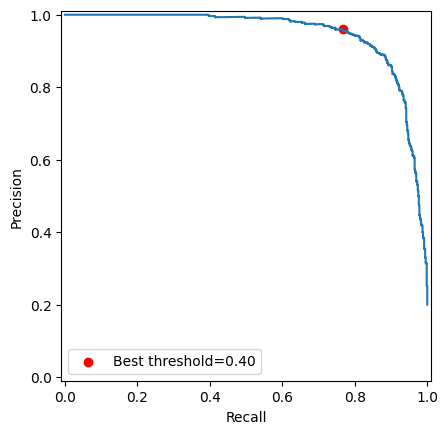

In [253]:
disp = PrecisionRecallDisplay(precision=precisions, recall=recalls)
disp.plot()
plt.scatter(best_recall, best_precision, color='red', label=f'Best threshold={best_threshold:.2f}')
plt.legend()
plt.show()

In [22]:
torch.cuda.empty_cache()

In [24]:
import gc
torch.cuda.empty_cache()
gc.collect()

5564